<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter8/Drift_Detection.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install river

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfcausalimpact 0.0.18 requires pandas<=2.2,>=1.3.5, but you have pandas 2.2.3 which is incompatible.


In [2]:
import numpy as np

np.random.seed(12345)
data_stream = np.concatenate(
    (np.random.randint(2, size=1000), np.random.randint(8, size=1000))
)

In [3]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

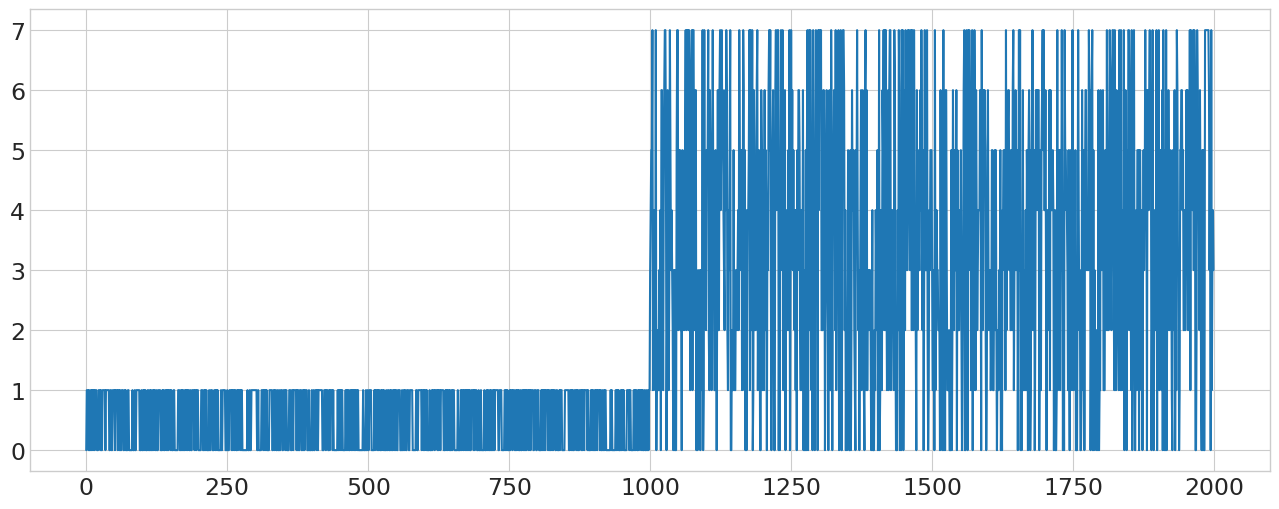

In [4]:
plt.figure(figsize=(16, 6))
plt.plot(data_stream)

In [5]:
def perform_test(drift_detector, data_stream):
    detected_indices = []
    for i, val in enumerate(data_stream):
        in_drift, in_warning = drift_detector.update(val)
        if in_drift:
            detected_indices.append(i)
    return detected_indices

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple


class SimpleADWIN:
    """Implémentation simplifiée de l'algorithme ADWIN pour la détection de drift."""

    def __init__(self, delta=0.002):
        self.delta = delta
        self.buffer = []
        self.drift_points = []
        self._mean = 0.0
        self._variance = 0.0
        self._n = 0

    def update(self, value):
        """Met à jour le détecteur avec une nouvelle valeur et retourne True si un drift est détecté."""
        self._n += 1
        self.buffer.append(value)

        # Mise à jour incrémentale de la moyenne et de la variance
        old_mean = self._mean
        self._mean += (value - self._mean) / self._n
        self._variance += (value - old_mean) * (value - self._mean)

        # Pour éviter les tests inutiles au début
        if self._n < 10:
            return False

        # Détection de drift
        if self._n >= 20:  # Vérifier seulement après un certain nombre d'observations
            variance = self._variance / (self._n - 1) if self._n > 1 else 0
            std_dev = np.sqrt(variance) if variance > 0 else 0

            # Calculer le seuil basé sur la distribution et le niveau de confiance
            threshold = std_dev * np.sqrt(2 * np.log(1.0 / self.delta) / self._n)

            # Vérifier les drifts en comparant des fenêtres
            for i in range(1, len(self.buffer) // 2):
                w0, w1 = self.buffer[:i], self.buffer[i:]
                mean0 = np.mean(w0)
                mean1 = np.mean(w1)

                if abs(mean0 - mean1) > threshold:
                    self.drift_points.append(self._n)
                    # Réinitialiser le buffer pour ne conserver que la nouvelle distribution
                    self.buffer = self.buffer[i:]
                    self._n = len(self.buffer)
                    self._mean = np.mean(self.buffer)
                    self._variance = np.var(self.buffer) * self._n
                    return True

        return False


class SimplePageHinkley:
    """Implémentation simplifiée de l'algorithme Page-Hinkley pour la détection de drift."""

    def __init__(self, delta=0.005, lambda_=50):
        self.delta = delta  # Seuil de changement
        self.lambda_ = lambda_  # Paramètre de sensibilité
        self.x_mean = 0.0
        self.sum = 0.0
        self.drift_points = []
        self._n = 0

    def update(self, value):
        """Met à jour le détecteur avec une nouvelle valeur et retourne True si un drift est détecté."""
        self._n += 1

        # Mise à jour de la moyenne
        if self._n == 1:
            self.x_mean = value
        else:
            self.x_mean = self.x_mean + (value - self.x_mean) / self._n

        # Calculer la déviation par rapport à la moyenne
        deviation = value - self.x_mean - self.delta

        # Mettre à jour la somme cumulative
        self.sum = max(0, self.sum + deviation)

        # Détection de drift
        if self.sum > self.lambda_:
            self.drift_points.append(self._n)
            # Réinitialiser
            self.x_mean = value
            self.sum = 0
            return True

        return False


def show_drift(data_stream, indices):
    """Affiche les données avec les points de drift marqués."""
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(data_stream, label='Données')

    for idx in indices:
        if idx < len(data_stream):
            ax.axvline(x=idx, color='r', linestyle='--', alpha=0.7)

    ax.set_title('Détection de drift')
    ax.set_xlabel('Temps')
    ax.set_ylabel('Valeur')
    ax.legend()
    plt.tight_layout()
    plt.show()


# Exemple d'utilisation
def detect_drift_with_adwin(data: List[float]) -> Tuple[List[float], List[int]]:
    """Détecte les drifts dans les données en utilisant ADWIN."""
    detector = SimpleADWIN(delta=0.002)
    drift_points = []

    for i, value in enumerate(data):
        if detector.update(value):
            drift_points.append(i)

    return data, drift_points


def detect_drift_with_page_hinkley(data: List[float]) -> Tuple[List[float], List[int]]:
    """Détecte les drifts dans les données en utilisant Page-Hinkley."""
    detector = SimplePageHinkley(delta=0.005, lambda_=50)
    drift_points = []

    for i, value in enumerate(data):
        if detector.update(value):
            drift_points.append(i)

    return data, drift_points


# Exemple de génération de données synthétiques avec drift
def generate_synthetic_data_with_drift(n=1000):
    np.random.seed(42)

    # Série sans drift
    data1 = np.random.normal(0, 1, n // 3)

    # Série avec changement de moyenne
    data2 = np.random.normal(3, 1, n // 3)

    # Série avec changement de variance
    data3 = np.random.normal(3, 3, n // 3)

    # Concaténation
    data = np.concatenate([data1, data2, data3])

    # Les points de drift sont connus
    true_drift_points = [n // 3, 2 * n // 3]

    return data, true_drift_points


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Points de drift détectés par ADWIN: [19, 23, 26, 55, 56, 70, 73, 74, 75, 101, 102, 103, 108, 109, 110, 119, 120, 125, 126, 165, 166, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 230, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 306, 307, 308, 309, 310, 311, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 444, 445, 446, 447, 448, 449, 450, 451, 453, 454, 455, 45

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

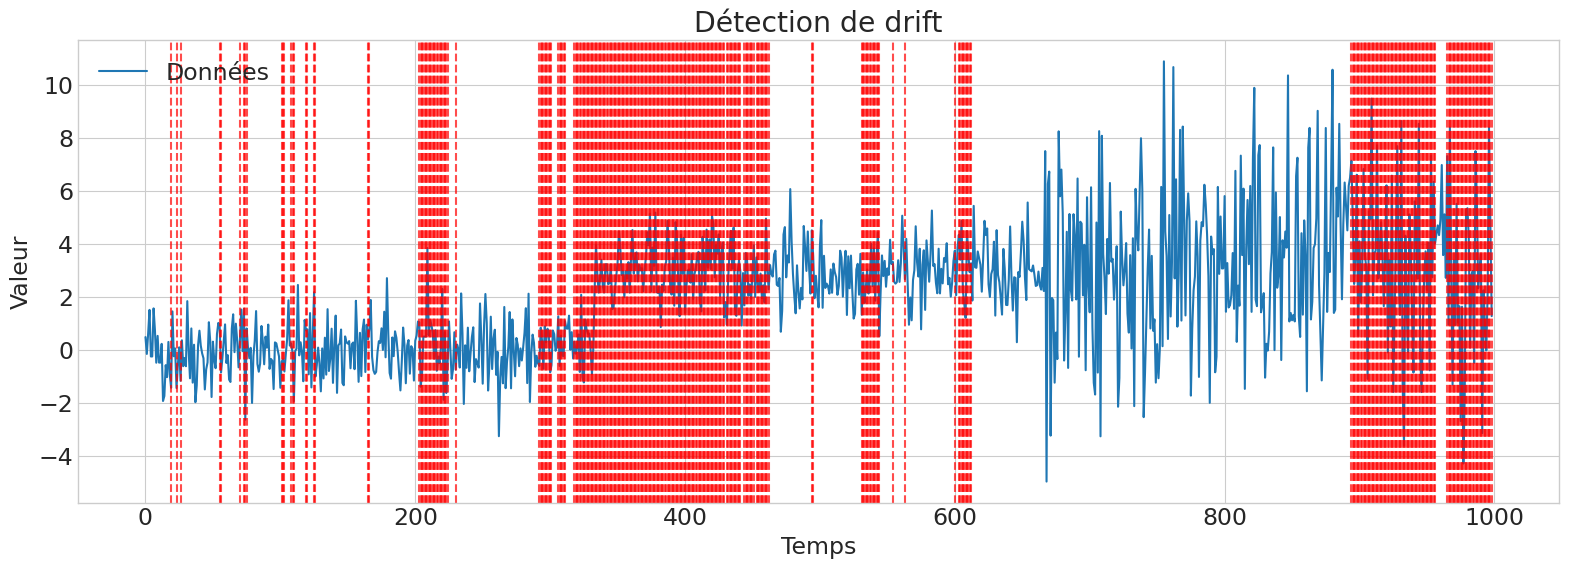

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Points de drift détectés par Page-Hinkley: [340, 404, 580, 891]


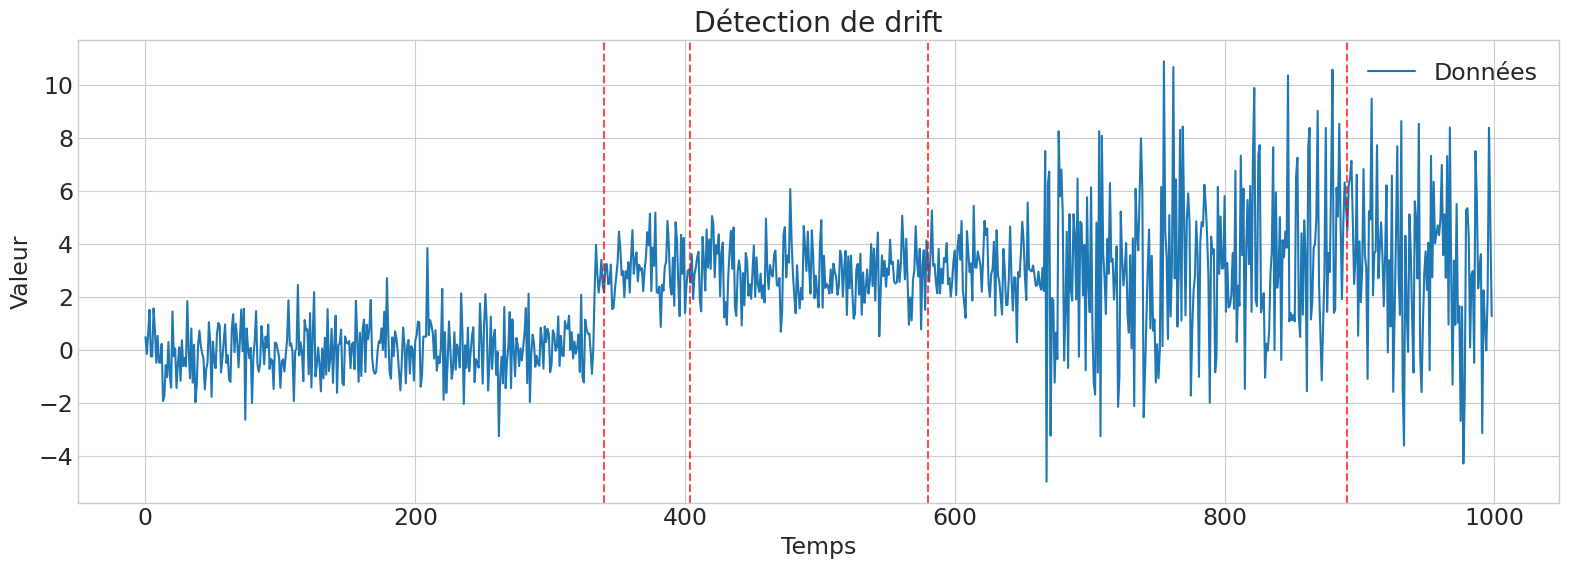

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Vrais points de drift: [333, 666]


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

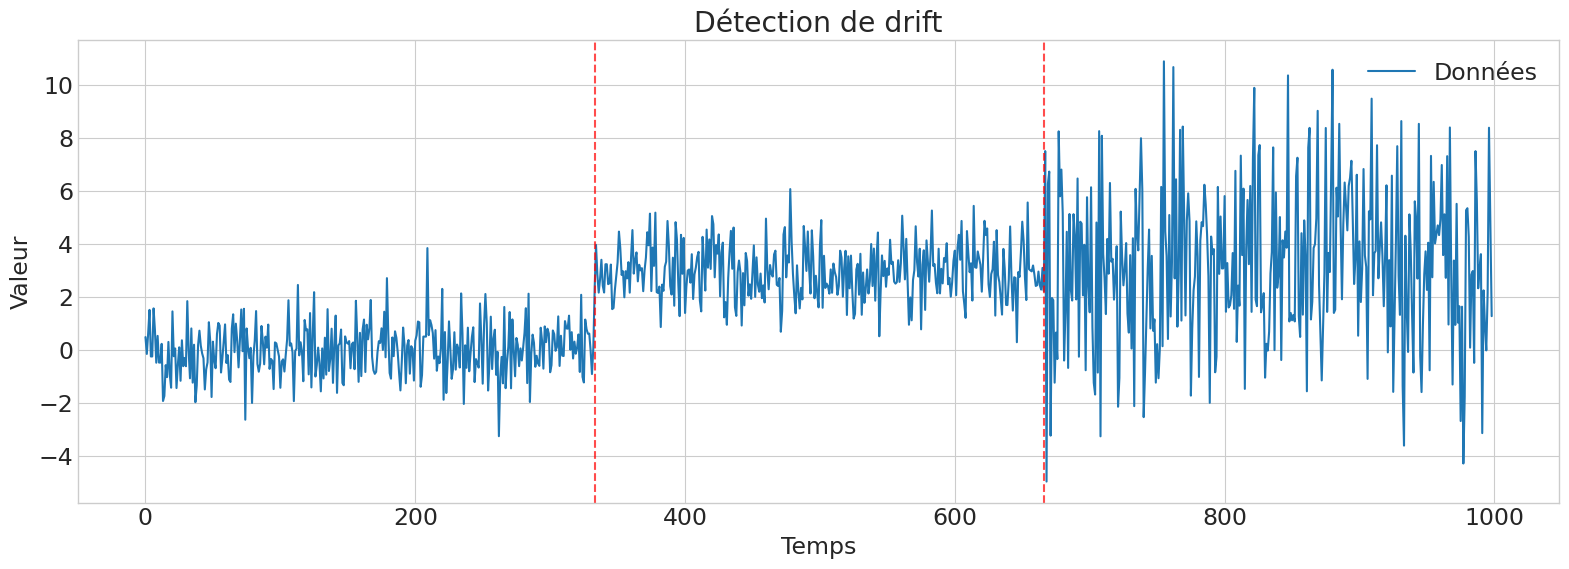

In [9]:
# Générer des données synthétiques
data, true_drift_points = generate_synthetic_data_with_drift(n=1000)

# Détection avec ADWIN
_, adwin_drift_points = detect_drift_with_adwin(data)
print(f"Points de drift détectés par ADWIN: {adwin_drift_points}")
show_drift(data, adwin_drift_points)

# Détection avec Page-Hinkley
_, ph_drift_points = detect_drift_with_page_hinkley(data)
print(f"Points de drift détectés par Page-Hinkley: {ph_drift_points}")
show_drift(data, ph_drift_points)

# Comparaison avec les vrais points de drift
print(f"Vrais points de drift: {true_drift_points}")
show_drift(data, true_drift_points)


NameError: name 'PageHinkley' is not defined